# WGAN-GP

元論文 : Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

### 論文のサマリ 

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを[-c, c]にクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（=GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

### アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

#### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

#### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

#### Generator

ResNetの活性化関数はReLU

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

#### Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='../assets/WGAN-gp_ResBlock.png' width=300>

## Import and Config

In [6]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CRITIC_N = 5
cfg.TRAIN.WGAN_GP_LAMBDA = 10

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [7]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x
    
    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=128, activation_fn=torch.nn.ReLU(), batch_norm=False, name=''):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        else:
            if batch_norm:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_bn' : torch.nn.BatchNorm2d(dim_first),
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
            else:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
        
        if batch_norm:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_bn' : torch.nn.BatchNorm2d(dim),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        x = torch.add(res_x, x)
        x = F.relu(x)
        return x
        
    
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.Linear(cfg.INPUT_Z_DIM, cfg.G_DIM * (cfg.OUTPUT_HEIGHT // 8) * (cfg.OUTPUT_WIDTH // 8)),
            'G_layer_1_reshape' : Reshape(cfg.G_DIM, cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_HEIGHT // 8),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_1_activation' : torch.nn.ReLU(),     
            
            'G_layer_2_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_1'),
            'G_layer_2_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_3_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_2'),
            'G_layer_3_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_4_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_3'),
            'G_layer_4_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
        
            'G_layer_out' : torch.nn.Conv2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=3, stride=1, padding=1),
            'G_layer_out_activation' : torch.nn.Tanh(),
        }))
        
    def forward(self, x):
        x = self.module(x)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()    
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_resBlock' : ResBlock(dim_first=cfg.OUTPUT_CHANNEL, dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_1'),
            'D_layer_1_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_2_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_2'),
            'D_layer_2_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_3_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_3'),

            'D_layer_4_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_4'),
            'D_layer_4_activation' : torch.nn.ReLU(),

            'D_layer_5_pool' : torch.nn.AdaptiveAvgPool2d((1, 1)),
            'D_layer_5_flatten' : Flatten(),
            'D_layer_out' : torch.nn.Linear(cfg.D_DIM, 1),
        }))

    def forward(self, x):
        x = self.module(x)
        return x
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [ ]:
def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

## Train

100%|██████████| 16/16 [00:00<00:00, 1721.89it/s]

Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> True
 - Vertical >> True
 - Rotation >> 1
all data num >> 5808
dataset was completely loaded
--
training start


Iter:50, LossG (fake:448.6492), LossD:-27.8924 (real:525.8092, fake:489.2108), WDistance:36.5984, GP:8.7060
Iter:100, LossG (fake:2334.3767), LossD:269.2689 (real:1588.2050, fake:1849.3279), WDistance:-261.1229, GP:8.1460
Iter:150, LossG (fake:56338.6016), LossD:25968.1680 (real:30724.7852, fake:52908.2891), WDistance:-22183.5039, GP:3784.6646
Iter:200, LossG (fake:-64267.2695), LossD:51531.2617 (real:-101710.0000, fake:-62196.4141), WDistance:-39513.5859, GP:12017.6758
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:112566.8281), LossD:33890.6172 (real:83549.6250, fake:111930.1953), WDistance:-28380.5703, GP:5510.0459
Iter:300, LossG (fake:-90437.3594), LossD:99070.4844 (real:-133963.9062, fake:-62179.8125), WDistance:-71784.0938, GP:27286.3945
Iter:350, LossG (fake:-479407.6562), LossD:128064.6016 (real:-467502.5000, fake:-386051.9375), WDistance:-81450.5625, GP:46614.0391
Iter:400, LossG (fake:-296001.2500), LossD:131384.5469 (real:-4343

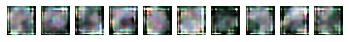

Iter:550, LossG (fake:291826.5625), LossD:79859.7656 (real:202586.5312, fake:256110.2969), WDistance:-53523.7656, GP:26335.9980
Iter:600, LossG (fake:52696.7578), LossD:77810.7656 (real:-7093.2607, fake:50153.2773), WDistance:-57246.5391, GP:20564.2305
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:-24213.0664), LossD:73151.1719 (real:-107810.2188, fake:-60782.9492), WDistance:-47027.2695, GP:26123.8984
Iter:700, LossG (fake:51839.0000), LossD:69867.5391 (real:408.3297, fake:46835.9961), WDistance:-46427.6680, GP:23439.8711
Iter:750, LossG (fake:107449.3047), LossD:73571.9531 (real:62378.7188, fake:110343.7734), WDistance:-47965.0547, GP:25606.8984
Iter:800, LossG (fake:-88311.9688), LossD:75286.3125 (real:-128584.1875, fake:-80466.5625), WDistance:-48117.6250, GP:27168.6914
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:-13608.7305), LossD:67659.9297 (real:-48358.3281, fake:-1064.3475), WDist

In [ ]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []
    list_loss_GP = []

    one = torch.FloatTensor([1])
    minus_one = one * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # sample X
            Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            
            #---
            # Gradient Penalty
            #---
            # sample epsilon from [0, 1]
            epsilon = np.random.random()

            # sample x_hat 
            x_hat = (epsilon * Xs + (1 - epsilon) * Gz).requires_grad_(True)
            
            Dx_hat = D(x_hat)
            musk = torch.ones_like(Dx_hat)
            gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
            gradients = gradients.view(-1, 1)
            gradient_penalty = cfg.TRAIN.WGAN_GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # loss backward
            loss_D_real.backward(one, retain_graph=True)
            loss_D_fake.backward(minus_one, retain_graph=True)
            gradient_penalty.backward(retain_graph=True)

            loss_D = loss_D_fake - loss_D_real + gradient_penalty
            Wasserstein_distance = loss_D_real - loss_D_fake

            opt_D.step()
            

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(one)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()
        _gradient_penalty = gradient_penalty.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                list_loss_GP.append(_gradient_penalty)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}, GP:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance, _gradient_penalty))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance,
                          'GP' : list_loss_GP})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

In [ ]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(cfg.TEST.ITERATION):
            z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
